<a href="https://colab.research.google.com/github/dajinfx/hanghaeAI2/blob/main/w4_1_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HuggingFace로 영화리뷰 감정 분석 모델 구현하기

과제: HuggingFace로 영화리뷰 감정 분석과 같은 text 분류 문제를 위한 모델을 구현합니다.

모델: microsoft/deberta-base-mnli
test

In [ ]:
!pip install transformers datasets evaluate accelerate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import random
import evaluate
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
n_labels = 3
batch_size = 64
max_len = 400
lr = 2e-5
n_epochs = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Dataset 준비

그 다음 감정 분석을 위해 사용할 imdb dataset을 `load_dataset` 함수로 다운로드 받습니다.

In [ ]:
data_ori = load_dataset("nyu-mll/glue", "mnli")
data = data_ori
data

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [ ]:
train_dataset = data["train"]
train_dataset[0]

{'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.',
 'hypothesis': 'Product and geography are what make cream skimming work. ',
 'label': 1,
 'idx': 0}

In [ ]:
train_df = pd.DataFrame(data["train"])  #과제 요구상 train split 만 사용가능
validation_matched_df = pd.DataFrame(data["validation_matched"])        #과제 요구상 미사용
validation_mismatched_df = pd.DataFrame(data["validation_mismatched"]) #과제 요구상 미사용
test_matched_df = pd.DataFrame(data["test_matched"])                    #과제 요구상 미사용
test_mismatched_df = pd.DataFrame(data["test_mismatched"])              #과제 요구상 미사용

In [ ]:
print(train_df.describe(include="all").transpose())
print("------------")
print(train_df["label"].value_counts())

               count  unique         top freq      mean            std  min  \
premise       392702  128144  I blinked.   12       NaN            NaN  NaN   
hypothesis    392702  391501         n/a   40       NaN            NaN  NaN   
label       392702.0     NaN         NaN  NaN   1.00001       0.816499  0.0   
idx         392702.0     NaN         NaN  NaN  196350.5  113363.447042  0.0   

                 25%       50%        75%       max  
premise          NaN       NaN        NaN       NaN  
hypothesis       NaN       NaN        NaN       NaN  
label            0.0       1.0        2.0       2.0  
idx         98175.25  196350.5  294525.75  392701.0  
------------
label
2    130903
1    130900
0    130899
Name: count, dtype: int64


In [ ]:
train_data, temp_data = train_test_split(train_df, test_size=0.3, random_state=42, stratify=train_df["label"])
val_data, test_data = train_test_split(temp_data, test_size=0.3333, random_state=42, stratify=temp_data["label"])

In [ ]:
from datasets import DatasetDict
dataset_dict = {
    'train': train_data,
    'val': val_data,
    'test': test_data,
}


In [ ]:
print(len(dataset_dict['train']))
print(len(dataset_dict['val']))
print(len(dataset_dict['test']))

274891
78544
39267


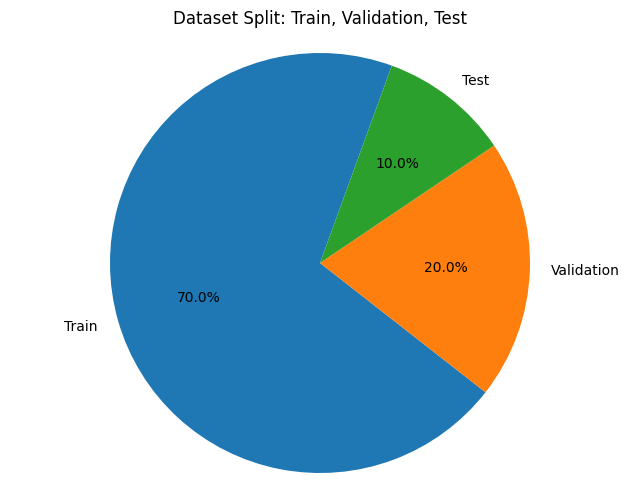

In [ ]:
import matplotlib.pyplot as plt

# Mocking dataset lengths as per the discussion since data is no longer available
train_size = len(dataset_dict['train'])
val_size =len(dataset_dict['val'])
test_size = len(dataset_dict['test'])

# Sizes for train, val, and test
sizes = [train_size, val_size, test_size]
labels = ['Train', 'Validation', 'Test']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=70)
plt.title("Dataset Split: Train, Validation, Test")
plt.axis('equal')  # Ensure the pie chart is a perfect circle
plt.show()

##Model choose and tokenize

In [ ]:
model_name = "microsoft/deberta-base-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

Some weights of the model checkpoint at microsoft/deberta-base-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from datasets import Dataset

# 转换为 Hugging Face Dataset 格式
train_data = Dataset.from_pandas(train_data)
val_data = Dataset.from_pandas(val_data)
test_data = Dataset.from_pandas(test_data)

In [ ]:
# tokenize and embedding
def preprocess_function(examples):
    return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding="max_length")

In [ ]:
# 对 train, val, test 数据集进行处理
train_data = train_data.map(preprocess_function, batched=True)
val_data = val_data.map(preprocess_function, batched=True)
test_data = test_data.map(preprocess_function, batched=True)


Map:   0%|          | 0/274891 [00:00<?, ? examples/s]

Map:   0%|          | 0/78544 [00:00<?, ? examples/s]

Map:   0%|          | 0/39267 [00:00<?, ? examples/s]

In [ ]:
train_data

Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 274891
})

In [ ]:
# "premise"、"hypothesis" 및 "idx" 열을 삭제하는 이유는 데이터 전처리 후 더 이상 필요하지 않기 때문입니다.
#모델은 분할된 특징(예: input_ids 및 attention_mask)과 레이블(label)만 사용하여 학습 및 평가를 수행합니다.
train_dt = train_data.remove_columns(["premise", "hypothesis", "idx"])
val_dt = val_data.remove_columns(["premise", "hypothesis", "idx"])
test_dt = test_data.remove_columns(["premise", "hypothesis", "idx"])

In [ ]:
train_dt

Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 274891
})

In [ ]:
#PyTorch tensor
train_dt.set_format("torch")
val_dt.set_format("torch")
test_dt.set_format("torch")

## Model 구현

이번에는 text 분류를 수행할 Transformer를 구현합니다.
이전에는 Transformer의 구성 요소들을 직접 구현하여 합쳤습니다.
이번에는 HuggingFace의 BERT를 활용하여 인자만 넘겨주는 식으로 구현해보겠습니다:

In [ ]:
print(model.config)  # 모델의 파라미터를 구조 보기

DebertaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "microsoft/deberta-base-mnli",
  "architectures": [
    "DebertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "CONTRADICTION",
    "1": "NEUTRAL",
    "2": "ENTAILMENT"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "CONTRADICTION": 0,
    "ENTAILMENT": 2,
    "NEUTRAL": 1
  },
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "c2p",
    "p2c"
  ],
  "position_biased_input": false,
  "relative_attention": true,
  "transformers_version": "4.47.1",
  "type_vocab_size": 0,
  "vocab_size": 

In [ ]:
from transformers import BertConfig

config = BertConfig()

config.hidden_size = 64  # BERT layer의 기본 hidden dimension
config.intermediate_size = 64  # FFN layer의 중간 hidden dimension
config.num_hidden_layers = 2  # BERT layer의 개수
config.num_attention_heads = 4  # Multi-head attention에서 사용하는 head 개수
config.num_labels = 2  # 마지막에 예측해야 하는 분류 문제의 class 개수

model = AutoModelForSequenceClassification.from_config(config)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='hf_transformer',  # 모델, log 등을 저장할 directory
    num_train_epochs= n_epochs,  # epoch 수
    per_device_train_batch_size=128,  # training data의 batch size
    per_device_eval_batch_size=128,  # validation data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,              # 학습을 진행하겠다는 의미
    do_eval=True,                # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=1e-3,  # optimizer에 사용할 learning rate
    load_best_model_at_end=True  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
)

training_args = TrainingArguments(
    output_dir="./results",           # 保存模型和结果的目录
    evaluation_strategy="epoch",     # 每个 epoch 后评估一次
    learning_rate=2e-5,              # 学习率
    per_device_train_batch_size=16,  # 每个设备上的训练批大小
    per_device_eval_batch_size=16,   # 每个设备上的评估批大小
    num_train_epochs=3,              # 训练轮次
    weight_decay=0.01,               # 权重衰减 (正则化)
    logging_dir="./logs",            # 日志保存目录
    save_total_limit=2,              # 只保留最近的两个检查点
)


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",    # 每轮评估一次
    learning_rate=2e-5,             # 学习率
    per_device_train_batch_size=16, # 批量大小
    num_train_epochs=3,             # 训练轮数
    weight_decay=0.01,              # 权重衰减
)
python3 -m DeBERTa.apps.run --task_name $task --do_train  \
  --data_dir $cache_dir/glue_tasks/$task \
  --eval_batch_size 128 \
  --predict_batch_size 128 \
  --output_dir $OUTPUT \
  --scale_steps 250 \
  --loss_scale 16384 \
  --accumulative_update 1 \
  --num_train_epochs 6 \
  --warmup 100 \
  --learning_rate 2e-5 \
  --train_batch_size 32 \
  --max_seq_len 128


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


BERT는 이전에 배운 Transformer의 architecture를 그대로 사용합니다.
그래서 BERT의 옵션들만 수정하면 vanilla Transformer를 쉽게 구현할 수 있습니다.

Transformer 구현 이외에 분류 문제에 맞춰 첫 번째 token을 linear classifier를 거치는 등의 과정은 `AutoModelForSequenceClassification`이 구현해줍니다.
즉, 우리가 `config`로 넘겨주는 BERT의 마지막에 linear classifier를 달아주는 역할을 합니다.

## 학습 코드

다음은 위에서 구현한 Transformer를 imdb로 학습하는 코드를 구현합니다.
먼저 다음과 같이 학습 인자들을 정의합니다.

각각의 부분들은 이전 주차에서 배웠던 내용들을 설정하는 것에 불과하다는 것을 알 수 있습니다.
요약하면 다음과 같습니다:
- `epochs`: training data를 몇 번 반복할 것인지 결정합니다.
- `batch_size`: training data를 얼마나 잘게 잘라서 학습할 것인지 결정합니다.
- `learning_rate`: optimizer의 learning rate를 얼마로 할 것인지 결정합니다.
위의 부분들 이외에도 사소한 구현 요소들도 지정할 수 있습니다.

다음은 loss 이외의 평가 함수들을 구현하는 방법입니다.

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")


def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

`evaluate` 또한 HuggingFace의 library로 다양한 평가 함수들을 제공하고 있습니다.
이번 실습의 경우, 감정 분석 문제는 분류 문제이기 때문에 정확도를 계산할 수 있습니다.
위와 같이 예측 결과(`pred`)와 실제 label(`labels`)가 주어졌을 때 정확도를 계산하는 것은 `evaluate`의 accuracy 함수로 구현할 수 있습니다.

마지막으로 위의 요소들을 종합하여 학습할 수 있는 `Trainer`를 구현합니다.

In [ ]:
from transformers import EarlyStoppingCallback


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=imdb_train,
    eval_dataset=imdb_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    # callbacks = [EarlyStoppingCallback(early_stopping_patience=1)]
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,                     # 微调的模型
    args=training_args,              # 训练参数
    train_dataset=train_dt,        # 训练数据
    eval_dataset=val_dt,           # 验证数据
)

모델, training 인자, training과 validation data, 부가적인 평가 함수, 그리고 tokenizer를 넘겨주면 끝입니다.
별개로 early stopping과 같은 기능도 주석 친 부분과 같이 `callbacks`로 구현할 수 있으니 참고해주시길 바랍니다.

위와 같이 만든 `Trainer`는 다음과 같이 학습을 할 수 있습니다.

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.517100,0.289358,0.886200
2,0.213200,0.407792,0.846400
3,0.116300,0.373934,0.885000
4,0.057200,0.468218,0.878200
5,0.030900,0.548320,0.875400
6,0.020400,0.570387,0.879000
7,0.016400,0.603839,0.880200
8,0.013500,0.646404,0.877200
9,0.012500,0.649665,0.877400
10,0.012200,0.653620,0.878800


TrainOutput(global_step=1570, training_loss=0.10099650135465488, metrics={'train_runtime': 394.9431, 'train_samples_per_second': 506.402, 'train_steps_per_second': 3.975, 'total_flos': 33699840000000.0, 'train_loss': 0.10099650135465488, 'epoch': 10.0})

보시다시피 training loss는 잘 떨어지는 반면, validation loss는 중간부터 쭉 올라가는 것을 볼 수 있습니다.
Overfitting이 일어났다고 볼 수 있습니다.

위와 같이 학습이 끝난 후 validation loss가 가장 낮은 모델을 가지고 test data의 성능을 평가하는 것은 다음과 같이 구현할 수 있습니다.

In [ ]:
trainer.evaluate(imdb_test)

{'eval_loss': 0.3246372938156128,
 'eval_accuracy': 0.86464,
 'eval_runtime': 25.3668,
 'eval_samples_per_second': 985.54,
 'eval_steps_per_second': 7.727,
 'epoch': 10.0}

이전에 학습 인자에서 `load_best_model_at_end=True`를 넘겨줬기 때문에 `trainer`는 학습이 끝난 후, 기본적으로 validation loss가 가장 좋은 모델을 가지고 `evaluate`를 진행합니다.
실제로 결과를 보면 `eval_loss`가 가장 낮은 validation loss와 유사한 것을 볼 수 있습니다.

평가할 때 사용한 모델은 다음과 같이 저장할 수 있습니다.

In [ ]:
trainer.save_model()

그리고 저장한 모델을 가지고 다른 예시들을 예측하는 것은 다음과 같이 구현할 수 있습니다.

In [ ]:
from transformers import pipeline


classifier = pipeline("sentiment-analysis", model="./hf_transformer/", device='cuda')
print(classifier("The movie was so disgusting..."))
print(classifier("The movie was so amazing!!"))

[{'label': 'LABEL_0', 'score': 0.9797601103782654}]

HuggingFace의 `pipeline`은 다양한 모델들에 대하여 서비스에 사용할 수 있는 형태들을 제공합니다.
여기서는 영화 리뷰가 주어졌을 때, label이 0(부정적인 리뷰)인지 1(긍정적인 리뷰)인지 예측 결과를 보여줄 뿐만 아니라 그 신뢰도를 `score`로 넘겨주게 됩니다.

이처럼 HuggingFace를 활용하면 모델이나 예측, 학습 코드를 구현할 필요 없이 인자로 설정값들만 넘겨주면 쉽게 구현 할 수 있습니다.

## Transfer learning

이번에는 task는 영화 리뷰 감정 분석으로 유지하되, 모델을 distilbert를 fine-tuning하는 것으로 바꿔보겠습니다.
모델은 다음과 같이 불러올 수 있습니다.

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


`id2label`과 `label2id`는 예측 결과의 가독성을 위해서 추가하였습니다.
기존과 같이 `AutoModelForSequenceClassification`를 사용하고 있습니다.
달라진 점은 `from_config`가 아닌 `from_pretrained`를 사용한다는 것입니다.
`from_pretrained`를 사용하면 HuggingFace hub에 있는 pre-trained 모델들을 사용할 수 있습니다.
감정 분석 문제의 class 수에 맞춰 `num_labels`를 2로 설정하면 모델 구현은 거의 끝났습니다.

이번에는 마지막 layer를 제외한 parameter들을 freeze해보겠습니다.
그 전에 freeze 해야 하는 layer들을 확인하기 위해 `model`을 출력해보겠습니다.

In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

보시다시피 `distilbert`는 기존의 distilbert 모델에 해당하고 나머지 `pre_classifier`, `classifier`는 text 분류를 위해 새롭게 추가된 layer들입니다.
즉, 다음과 같이 `distilbert`에 해당하는 parameter들만 freeze하면 됩니다.

In [ ]:
for param in model.distilbert.parameters():
  param.requires_grad = False

이러면 모델 구현은 완전히 마쳤습니다.
다음은 distilbert를 pre-train할 때 사용했던 tokenizer를 불러오고, 이 tokenizer를 가지고 이전과 똑같이 imdb dataset를 전처리합니다.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def preprocess_function(data):
    return tokenizer(data["text"], truncation=True)

imdb_tokenized = imdb.map(preprocess_function, batched=True)
imdb_split = imdb_tokenized['train'].train_test_split(test_size=0.2)
imdb_train, imdb_val = imdb_split['train'], imdb_split['test']
imdb_test = imdb_tokenized['test']

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

나머지는 기존의 학습과정과 완전히 동일합니다. `training_args`는 기존과 똑같이 활용할 때 distilbert를 fine-tuning하는 코드는 다음과 같습니다.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=imdb_train,
    eval_dataset=imdb_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

trainer.train()
trainer.save_model()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.402800,0.416730,0.815000
2,0.358200,0.336039,0.860400
3,0.342900,0.372907,0.830800
4,0.342100,0.343459,0.841400
5,0.338800,0.377508,0.834400
6,0.335800,0.315672,0.862200


KeyboardInterrupt: 

학습한 모델에 대한 결과는 다음과 같습니다.

In [ ]:
trainer.predict(imdb_test)

In [ ]:
classifier = pipeline("sentiment-analysis", model="./hf_distilbert/", device='cuda')
print(classifier("The movie was so disgusting..."))
print(classifier("The movie was so amazing!!"))